# Bank Customer Churn Prediction
### Objective
Develop an end-to-end machine learning solution to predict bank customer churn and support data-driven customer retention strategies.

### Business Impact
* Reduce customer attrition

* Improve customer lifetime value

* Enable targeted retention campaigns

* Reduce acquisition costs

### Dataset Overview

The dataset contains customer banking information including demographics, account details, activity status, and satisfaction metrics used to predict churn.

Key features include:

* Customer demographics (Age, Gender, Geography)

* Account information (Balance, Credit Score, Tenure)

* Engagement metrics (Active status, Complaints, Satisfaction)

* Banking products & card details

* Target variable: Exited (Churn)

In [3]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split, RandomizedSearchCV ,GridSearchCV
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.metrics import ( accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay) 
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Data Cleaning & Preprocessing

In [4]:
df = pd.read_csv(f'Customer-Churn-Records.csv')

In [5]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

In [7]:
df['Exited'].value_counts()

Exited
0    7962
1    2038
Name: count, dtype: int64

In [8]:
print(df.isnull().sum())

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64


### EDA insights

In [9]:
sns.set_style("whitegrid")

### 1. Churn Distribution

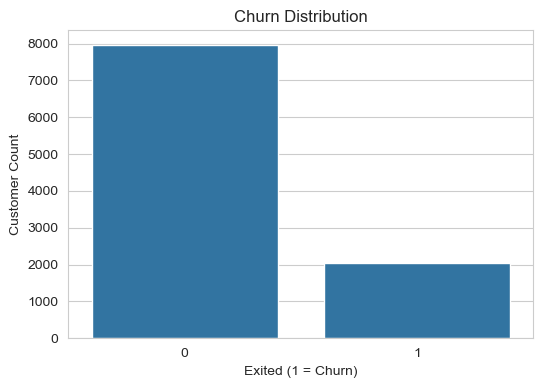

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x='Exited', data=df)
plt.title("Churn Distribution")
plt.xlabel("Exited (1 = Churn)")
plt.ylabel("Customer Count")
plt.show()

#### Insight 1: dataset have lower number of chrun

Observation: Dataset is imbalance

#### 2. Active Member vs Churn

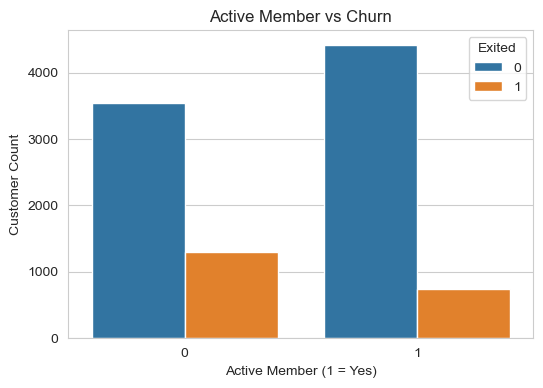

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x='IsActiveMember', hue='Exited', data=df)

plt.title("Active Member vs Churn")
plt.xlabel("Active Member (1 = Yes)")
plt.ylabel("Customer Count")

plt.show()


#### Insight 2: Active Members Rarely Churn

Observation: Customers who are inactive show much higher churn rates.

Insight: Engagement level strongly influences customer retention.

#### 3. Number of Products vs Churn

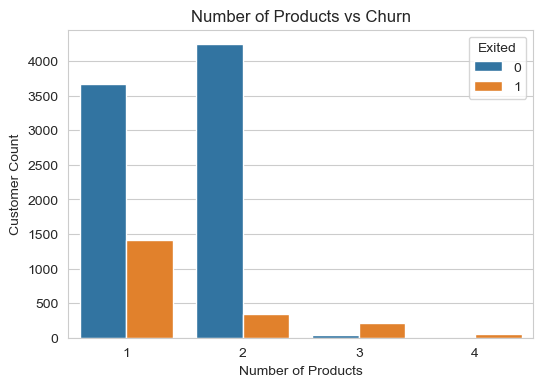

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x='NumOfProducts', hue='Exited', data=df)

plt.title("Number of Products vs Churn")
plt.xlabel("Number of Products")
plt.ylabel("Customer Count")

plt.show()



#### Insight 3: Customers With Only One Product Churn More

Observation: Customers holding only one bank product show higher churn.

Insight: Customers using multiple products are more loyal.

#### 4. Age vs Churn

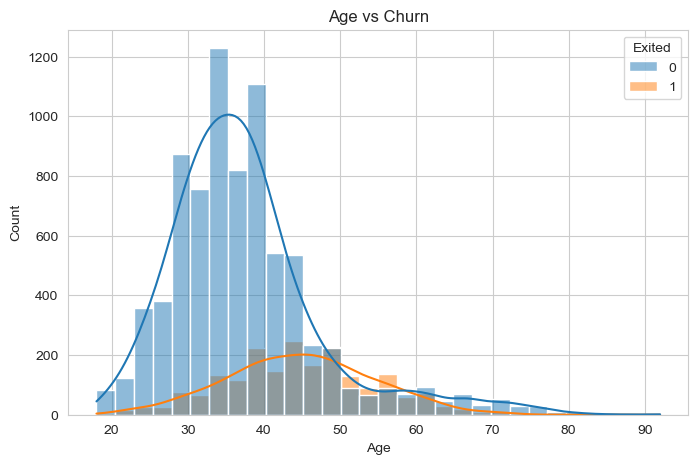

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='Age', hue='Exited', bins=30, kde=True)

plt.title("Age vs Churn")
plt.xlabel("Age")

plt.show()


#### Insight 4:- Middle-aged customers show a higher probability of leaving compared to younger customers.

Observation : Most non-churn customers are concentrated around 30–40 years.

### 5. Correlation Heatmap

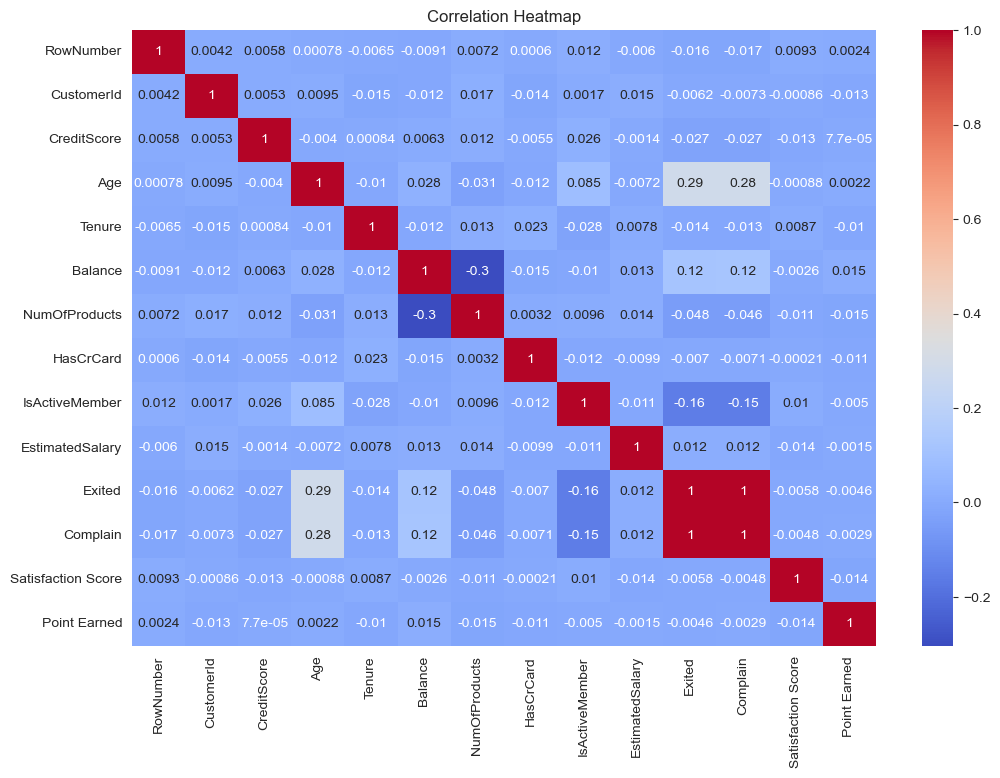

In [14]:
plt.figure(figsize=(12,8))

numeric_df = df.select_dtypes(include=['int64','float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')

plt.title("Correlation Heatmap")
plt.show()


### Insight 5:
Observation:
The correlation heatmap shows that the variable 'Complain' is almost perfectly correlated with the target variable 'Exited'.

Insight:
This indicates that customers who file complaints almost always churn, making the feature redundant and causing data leakage.

Action:
To prevent unrealistic model performance, the 'Complain' column is removed during feature engineering.


### Feature Engineering

In [15]:
df = df.drop(columns=['RowNumber','CustomerId','Surname','Complain'])

In [16]:
df['EngagementScore'] = (
    df['IsActiveMember'] +
    df['NumOfProducts'] +
    df['HasCrCard']
)


In [17]:
target = "Exited"
features = [col for col in df.columns if col != target]
X = df[features]
y = df[target]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.25,
        stratify=y,
        random_state=42
    )

### Pipeline

In [19]:
categorycal_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num",StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(drop='first'), categorycal_cols)
    ]
)

pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            scale_pos_weight=4,
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.7,
            colsample_bytree=0.7,
            tree_method="hist",
            gamma=0.5,
            min_child_weight=3,
            random_state=42
        ))
    ])

### Hyperparameter tuning

In [20]:
param_dist = {
        "model__max_depth": [3,4,5],
        "model__learning_rate": [0.05, 0.1],
        "model__subsample": [0.9, 0.8],
        "model__colsample_bytree": [0.8, 0.9],
        "model__n_estimators": [400, 600],
        "model__gamma": [0,0.1, 0.5], 
        "model__min_child_weight": [3, 5],
        "model__scale_pos_weight": [3, 4]
    }

grid_search = GridSearchCV(
    pipe,
    param_dist,
    cv=4,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 4 folds for each of 576 candidates, totalling 2304 fits
{'model__colsample_bytree': 0.8, 'model__gamma': 0, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__min_child_weight': 5, 'model__n_estimators': 400, 'model__scale_pos_weight': 4, 'model__subsample': 0.9}


In [21]:
grid_search.best_params_

{'model__colsample_bytree': 0.8,
 'model__gamma': 0,
 'model__learning_rate': 0.05,
 'model__max_depth': 3,
 'model__min_child_weight': 5,
 'model__n_estimators': 400,
 'model__scale_pos_weight': 4,
 'model__subsample': 0.9}

In [22]:
best_params = {
    k.replace("model__", ""): v
    for k, v in grid_search.best_params_.items()
}


In [23]:
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [24]:
preprocessor.fit(X_train_final)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['CreditScore', 'Age', 'Tenure', 'Balance',
                                  'NumOfProducts', 'HasCrCard',
                                  'IsActiveMember', 'EstimatedSalary',
                                  'Satisfaction Score', 'Point Earned',
                                  'EngagementScore']),
                                ('cat', OneHotEncoder(drop='first'),
                                 ['Geography', 'Gender', 'Card Type'])])

In [25]:
X_train_proc = preprocessor.transform(X_train_final)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)


In [26]:
final_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    early_stopping_rounds=30,
    **best_params
)

final_model.fit(
    X_train_proc,
    y_train_final,
    eval_set=[(X_val_proc, y_val)],
    verbose=True
)


[0]	validation_0-auc:0.79256
[1]	validation_0-auc:0.81523
[2]	validation_0-auc:0.81230
[3]	validation_0-auc:0.81371
[4]	validation_0-auc:0.81414
[5]	validation_0-auc:0.82044


[6]	validation_0-auc:0.83285
[7]	validation_0-auc:0.83067
[8]	validation_0-auc:0.83190
[9]	validation_0-auc:0.83462
[10]	validation_0-auc:0.83220
[11]	validation_0-auc:0.83352
[12]	validation_0-auc:0.83372
[13]	validation_0-auc:0.83657
[14]	validation_0-auc:0.83664
[15]	validation_0-auc:0.84012
[16]	validation_0-auc:0.83958
[17]	validation_0-auc:0.84230
[18]	validation_0-auc:0.84472
[19]	validation_0-auc:0.84652
[20]	validation_0-auc:0.84806
[21]	validation_0-auc:0.84846
[22]	validation_0-auc:0.84972
[23]	validation_0-auc:0.85130
[24]	validation_0-auc:0.85160
[25]	validation_0-auc:0.85207
[26]	validation_0-auc:0.85286
[27]	validation_0-auc:0.85253
[28]	validation_0-auc:0.85156
[29]	validation_0-auc:0.85153
[30]	validation_0-auc:0.85268
[31]	validation_0-auc:0.85222
[32]	validation_0-auc:0.85250
[33]	validation_0-auc:0.85311
[34]	validation_0-auc:0.85453
[35]	validation_0-auc:0.85587
[36]	validation_0-auc:0.85588
[37]	validation_0-auc:0.85548
[38]	validation_0-auc:0.85532
[39]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, ...)

### Evaluation metrics

In [27]:
y_pred = final_model.predict(X_test_proc)
y_proba = final_model.predict_proba(X_test_proc)[:, 1]

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC_AUC": roc_auc_score(y_test, y_proba)
}

metrics


{'Accuracy': 0.7936,
 'Precision': 0.49551856594110116,
 'Recall': 0.7603143418467584,
 'F1': 0.6,
 'ROC_AUC': np.float64(0.872653364501751)}

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1991
           1       0.50      0.76      0.60       509

    accuracy                           0.79      2500
   macro avg       0.71      0.78      0.73      2500
weighted avg       0.84      0.79      0.81      2500



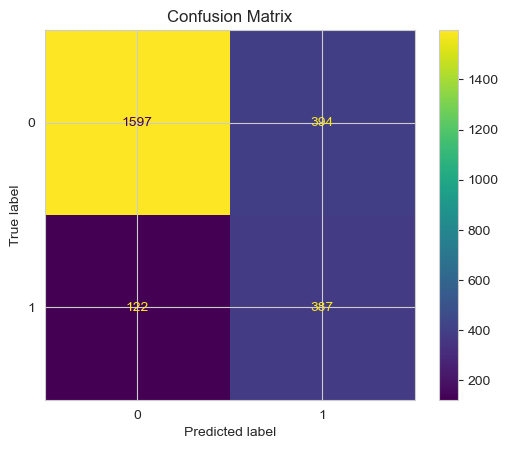

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()

### Confusion Matrix Insights

• The model correctly identifies 387 customers likely to churn.

• Only 122 churn cases are missed, indicating strong recall performance.

• Some customers are incorrectly predicted as churners (394), which may lead to unnecessary retention efforts.


### Feature importance

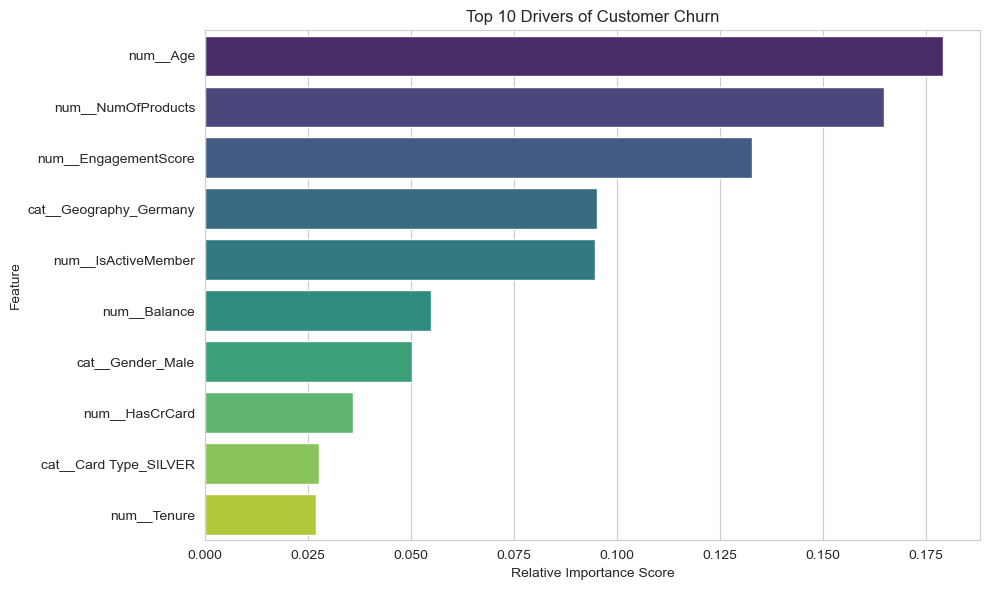

In [30]:
feature_names = preprocessor.get_feature_names_out()
    
    # 2. Get the importance scores
importances = final_model.feature_importances_
    
    # 3. Organize into a DataFrame
feat_df = pd.DataFrame({
   "Feature": feature_names,
    "Importance": importances
    }).sort_values(by="Importance", ascending=False)
    
    # 4. Plot the Top 10
plt.figure(figsize=(10, 6))
    
    # FIXED: Added hue="Feature" and legend=False to remove the warning
sns.barplot(
        data=feat_df.head(10), 
        x="Importance", 
        y="Feature", 
        hue="Feature", 
        palette="viridis", 
        legend=False
    )
    
    # FIXED: Removed the emoji to stop the font error
plt.title("Top 10 Drivers of Customer Churn") 
    
plt.xlabel("Relative Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Final Insights & Recommendations

• Active and engaged customers are significantly less likely to churn.

• Customers using only one banking product show higher churn risk.

• Middle-aged customers demonstrate higher churn probability.

• Complaint behavior strongly correlates with churn, indicating service quality impacts retention.

Business Recommendations:
• Promote cross-selling of banking products.
• Increase engagement programs for inactive customers.
• Improve complaint resolution processes.
• Provide targeted offers to high-risk customer segments.
